In [48]:
import zipfile
import pandas as pd
from pathlib import Path

DATA_ZIP = Path("C:\\Users\\ik_ad\\Downloads\\city_bike_NYC.zip")  # adjust if needed

# All known variants across Citibike years
COL_MAP = {
    "starttime": ["starttime","start_time","started_at","start_time_local"],
    "stoptime":  ["stoptime","stop_time","ended_at","end_time_local"],
    "start station id": ["start station id","start_station_id","start station id ","start id"],
    "end station id":   ["end station id","end_station_id","end station id ","end id"],
    "start station latitude": ["start station latitude","start_lat","start latitude","start station lat","start_latitude","startlat"],
    "start station longitude": ["start station longitude","start_lng","start longitude","start station lon","start_longitude","startlon"],
    "end station latitude": ["end station latitude","end_lat","end latitude","end station lat","end_latitude","endlat"],
    "end station longitude": ["end station longitude","end_lng","end longitude","end station lon","end_longitude","endlon"],
}

def normalize_columns(df):
    rename_dict = {}
    lower_cols = {c.lower(): c for c in df.columns}

    for std_name, variants in COL_MAP.items():
        for v in variants:
            if v.lower() in lower_cols:
                rename_dict[lower_cols[v.lower()]] = std_name
                break
    
    return df.rename(columns=rename_dict)

dfs = []
with zipfile.ZipFile(DATA_ZIP, 'r') as z:
    csvs = [f for f in z.namelist() if f.lower().endswith('.csv')]
    print("Found CSV files:", len(csvs))

    # You may lower this if speed is needed:
    NROWS_PER_FILE = 35_000

    for file in csvs:
        with z.open(file) as f:
            df = pd.read_csv(f, low_memory=False, nrows=NROWS_PER_FILE)
            df = normalize_columns(df)

            # Keep only rows with valid coords
            needed = [
                "start station latitude","start station longitude",
                "end station latitude","end station longitude"
            ]
            df = df.dropna(subset=[c for c in needed if c in df])

            dfs.append(df)

trips = pd.concat(dfs, ignore_index=True)

print("Trips loaded:", len(trips))
trips.head()


Found CSV files: 2
Trips loaded: 70000


,ride_id,rideable_type,starttime,stoptime,start_station_name,start station id,end_station_name,end station id,start station latitude,start station longitude,end station latitude,end station longitude,member_casual
0,C1B92340DDCAD1B0,classic_bike,2024-01-15 18:13:13,2024-01-15 18:17:09,St Marks Pl & 2 Ave,5669.1,1 Ave & E 6 St,5626.15,40.728419,-73.987140,40.726331,-73.986169,member
1,40801C182025253C,electric_bike,2024-01-23 18:00:07,2024-01-23 18:02:11,St Marks Pl & 2 Ave,5669.1,1 Ave & E 6 St,5626.15,40.728374,-73.986988,40.726331,-73.986169,member
2,2BA6C231ADA6B83F,electric_bike,2024-01-23 09:44:05,2024-01-23 09:47:23,St Marks Pl & 2 Ave,5669.1,E 4 St & Ave B,5515.08,40.728279,-73.987133,40.723347,-73.982659,member
3,C2A64E523C94F719,electric_bike,2024-01-23 13:32:38,2024-01-23 13:34:40,St Marks Pl & 2 Ave,5669.1,1 Ave & E 6 St,5626.15,40.728484,-73.987595,40.726331,-73.986169,member
4,39D58436339BD8D5,electric_bike,2024-01-08 11:44:50,2024-01-08 12:04:23,Pearl St & Hanover Square,4993.02,Lafayette St & E 8 St,5788.13,40.704467,-74.008512,40.730207,-73.991026,member


In [49]:
# ====== SPEED CONFIG ======
# Sampling caps (tune these first)
SAMPLE_TRIPS_FOR_K   = 50_000   # for elbow/silhouette
FIT_TRIPS_CAP        = 200_000  # max rows for final trip clustering
SAMPLE_STATIONS_FOR_K= 2_000    # for elbow/silhouette on stations

# K search ranges (smaller = faster)
TRIP_K_RANGE     = range(4, 9)  # try k=4..8
STATION_K_RANGE  = range(3, 7)  # try k=3..6

# MiniBatchKMeans params (fast)
MB_BATCH_SIZE    = 4096
MB_MAX_ITER      = 80
MB_N_INIT        = 5  # lower n_init to save time

# Scaling toggle (skipping scaler saves time, but silhouette less comparable)
USE_SCALER = True
# ==========================

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Build 4-tuples
trip_feats = trips[['start station latitude','end station latitude',
                    'start station longitude','end station longitude']].rename(
                    columns={'start station latitude':'s_lat','end station latitude':'e_lat',
                             'start station longitude':'s_lng','end station longitude':'e_lng'}).copy()

# Sample for k-selection
trip_sample = trip_feats.sample(n=min(SAMPLE_TRIPS_FOR_K, len(trip_feats)),
                                random_state=42) if len(trip_feats) > SAMPLE_TRIPS_FOR_K else trip_feats

def maybe_scale(X, fit=True, scaler_obj=[None]):
    if not USE_SCALER:
        return X.values if hasattr(X, 'values') else X
    if fit or scaler_obj[0] is None:
        scaler_obj[0] = StandardScaler().fit(X)
    return scaler_obj[0].transform(X)

Xs_trip = maybe_scale(trip_sample, fit=True)

In [51]:
inertias, sils = [], []
for k in TRIP_K_RANGE:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=MB_N_INIT,
                         batch_size=MB_BATCH_SIZE, max_iter=MB_MAX_ITER,
                         random_state=42)
    km.fit(Xs_trip)
    inertias.append(km.inertia_)
    labels = km.labels_
    sils.append(silhouette_score(Xs_trip, labels) if len(np.unique(labels))>1 else np.nan)

# pick k with peak silhouette (simple & robust)
K_TRIPS = TRIP_K_RANGE[int(np.nanargmax(sils))]
print("Chosen k for trips:", K_TRIPS)


Chosen k for trips: 4


In [52]:
# Cap final fit size
trip_fit = (trip_feats.sample(n=min(FIT_TRIPS_CAP, len(trip_feats)), random_state=17)
            if len(trip_feats) > FIT_TRIPS_CAP else trip_feats)

X_full_rand = maybe_scale(trip_fit, fit=True)
X_full_plus = X_full_rand  # same scaling

km_random = MiniBatchKMeans(n_clusters=K_TRIPS, init='random', n_init=MB_N_INIT,
                            batch_size=MB_BATCH_SIZE, max_iter=MB_MAX_ITER, random_state=17)
km_plus   = MiniBatchKMeans(n_clusters=K_TRIPS, init='k-means++', n_init=MB_N_INIT,
                            batch_size=MB_BATCH_SIZE, max_iter=MB_MAX_ITER, random_state=17)

km_random.fit(X_full_rand)
km_plus.fit(X_full_plus)

from sklearn.metrics import silhouette_score
sil_rand = silhouette_score(X_full_rand, km_random.labels_) if len(set(km_random.labels_))>1 else np.nan
sil_plus = silhouette_score(X_full_plus, km_plus.labels_) if len(set(km_plus.labels_))>1 else np.nan

print({"k": K_TRIPS,
       "random_inertia": km_random.inertia_, "random_silhouette": float(sil_rand),
       "plus_inertia": km_plus.inertia_, "plus_silhouette": float(sil_plus)})


{'k': 4, 'random_inertia': 85720.0055672884, 'random_silhouette': 0.3437404395087686, 'plus_inertia': 88126.11014255496, 'plus_silhouette': 0.3650162432657967}


In [53]:
def destandardize_centers(km, ref_df):
    if not USE_SCALER:
        return pd.DataFrame(km.cluster_centers_, columns=ref_df.columns)
    scaler = StandardScaler().fit(ref_df.values)
    centers = scaler.inverse_transform(km.cluster_centers_)
    return pd.DataFrame(centers, columns=ref_df.columns)

centers_rand = destandardize_centers(km_random, trip_fit)
centers_plus = destandardize_centers(km_plus, trip_fit)


In [54]:
# Hour extraction is expensive; speed up by trusting pandas to_datetime once:
st = pd.to_datetime(trips['starttime'], errors='coerce')
et = pd.to_datetime(trips['stoptime'],  errors='coerce')
trips['_shour'] = st.dt.hour
trips['_ehour'] = et.dt.hour

start_counts = (trips.groupby(['start station id','_shour']).size()
                .unstack(fill_value=0).reindex(columns=range(24), fill_value=0))
end_counts   = (trips.groupby(['end station id','_ehour']).size()
                .unstack(fill_value=0).reindex(columns=range(24), fill_value=0))
start_counts.index.name = end_counts.index.name = 'sid'
station_hourly = start_counts.add(end_counts, fill_value=0).astype('int32')

# Sample for k-selection
station_sample = (station_hourly.sample(n=min(SAMPLE_STATIONS_FOR_K, len(station_hourly)),
                                        random_state=42)
                  if len(station_hourly) > SAMPLE_STATIONS_FOR_K else station_hourly)

Xs_stat = maybe_scale(station_sample, fit=True)

inertias_s, sils_s = [], []
for k in STATION_K_RANGE:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=MB_N_INIT,
                         batch_size=MB_BATCH_SIZE, max_iter=MB_MAX_ITER, random_state=42)
    km.fit(Xs_stat)
    inertias_s.append(km.inertia_)
    sils_s.append(silhouette_score(Xs_stat, km.labels_) if len(set(km.labels_))>1 else np.nan)

K_STATIONS = STATION_K_RANGE[int(np.nanargmax(sils_s))]
print("Chosen k for stations:", K_STATIONS)


Chosen k for stations: 3


{'k': 3, 'random_inertia': 34341.43242050762, 'random_silhouette': 0.6713970651272986, 'plus_inertia': 34535.331275289216, 'plus_silhouette': 0.5732999703377673}


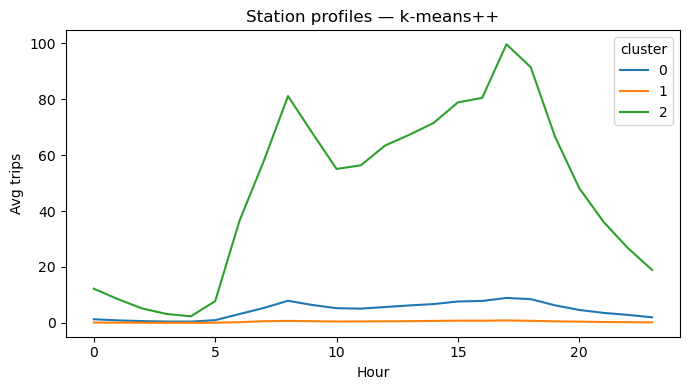

In [55]:
X_stat_full = maybe_scale(station_hourly, fit=True)

km_s_rand = MiniBatchKMeans(n_clusters=K_STATIONS, init='random', n_init=MB_N_INIT,
                            batch_size=MB_BATCH_SIZE, max_iter=MB_MAX_ITER, random_state=17).fit(X_stat_full)
km_s_plus = MiniBatchKMeans(n_clusters=K_STATIONS, init='k-means++', n_init=MB_N_INIT,
                            batch_size=MB_BATCH_SIZE, max_iter=MB_MAX_ITER, random_state=17).fit(X_stat_full)

sil_s_rand = silhouette_score(X_stat_full, km_s_rand.labels_) if len(set(km_s_rand.labels_))>1 else np.nan
sil_s_plus = silhouette_score(X_stat_full, km_s_plus.labels_) if len(set(km_s_plus.labels_))>1 else np.nan

print({"k": K_STATIONS,
       "random_inertia": km_s_rand.inertia_, "random_silhouette": float(sil_s_rand),
       "plus_inertia": km_s_plus.inertia_, "plus_silhouette": float(sil_s_plus)})

# Average 24h profiles for interpretation (k-means++)
labels_plus = km_s_plus.labels_
avg_plus = (station_hourly.assign(cluster=labels_plus)
            .groupby('cluster').mean().iloc[:, :24])
ax = avg_plus.T.plot(figsize=(7,4)); ax.set_xlabel("Hour"); ax.set_ylabel("Avg trips"); ax.set_title("Station profiles — k-means++")
plt.tight_layout(); plt.show()


In [56]:
X_stat = StandardScaler().fit_transform(station_hourly.values.astype(float))
km_s_rand = KMeans(n_clusters=K_STATIONS, init="random", n_init=20, random_state=42).fit(X_stat)
km_s_plus = KMeans(n_clusters=K_STATIONS, init="k-means++", n_init=20, random_state=42).fit(X_stat)

lab_s_rand, lab_s_plus = km_s_rand.labels_, km_s_plus.labels_
sil_s_rand = silhouette_score(X_stat, lab_s_rand) if len(np.unique(lab_s_rand))>1 else np.nan
sil_s_plus = silhouette_score(X_stat, lab_s_plus) if len(np.unique(lab_s_plus))>1 else np.nan

station_summary = pd.DataFrame({
    "algorithm": ["k-means (random)","k-means++"],
    "k": [K_STATIONS, K_STATIONS],
    "inertia": [km_s_rand.inertia_, km_s_plus.inertia_],
    "silhouette": [sil_s_rand, sil_s_plus]
})
station_summary


,algorithm,k,inertia,silhouette
0,k-means (random),3,28934.079576,0.868152
1,k-means++,3,28923.235739,0.875186


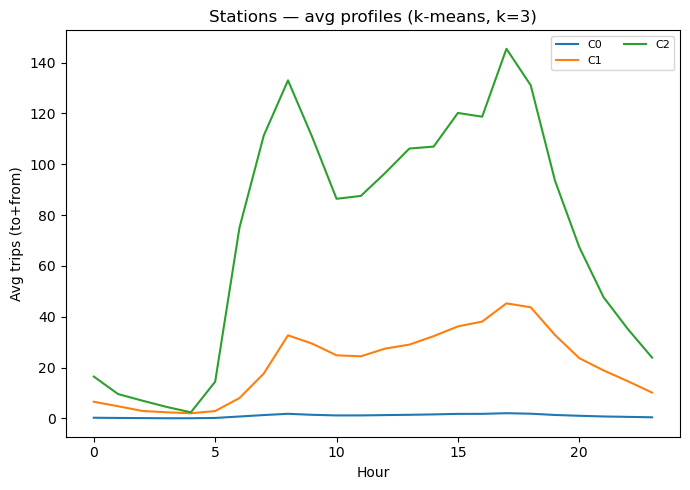

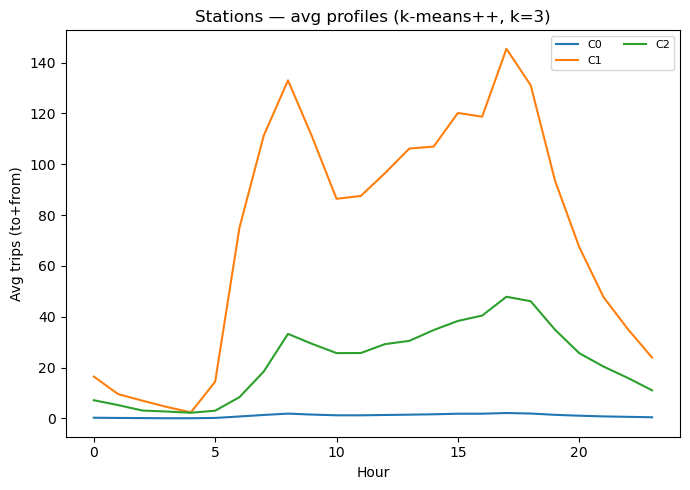

In [57]:
def plot_avg_profiles(labels, title):
    df = station_hourly.copy()
    df["cluster"] = labels
    avg = df.groupby("cluster").mean().iloc[:, :24]
    plt.figure(figsize=(7,5))
    for cid, row in avg.iterrows():
        plt.plot(range(24), row.values, label=f"C{cid}")
    plt.xlabel("Hour"); plt.ylabel("Avg trips (to+from)")
    plt.legend(ncol=2, fontsize=8); plt.title(title)
    plt.tight_layout(); plt.show()
    return avg

avg_rand = plot_avg_profiles(lab_s_rand, f"Stations — avg profiles (k-means, k={K_STATIONS})")
avg_plus = plot_avg_profiles(lab_s_plus, f"Stations — avg profiles (k-means++, k={K_STATIONS})")
